In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import corner

from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# If running on Apple Silicon or CUDA is available, use the GPU.

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### Data loading and preprocessing for training
In this notebook, we will load and preprocess the data generated with the notebook `data_generation.ipynb` and saved as `data/training_dataset.pkl`.

In [3]:
# Get the absolute path of the directory where the notebook is located
print("Current working directory", os.getcwd())
data_folder = os.path.join(os.getcwd(), 'genAI-Days/01_normalizing_flows/data')
file_name = os.path.join(data_folder, 'dataset.pkl')

if not os.path.isfile(file_name):
    raise ValueError(f"File {file_name} does not exist, correct path or generate data set.")

with open(file_name, 'rb') as f:
    data = pickle.load(f)
print('Sucessfully loaded dataset with', len(data['hp']), 'waveforms.')

Current working directory /Users/akofler/Desktop/courses_and_tutorials/2024_genAI_days_ODSL
Sucessfully loaded dataset with 10000 waveforms.


In [4]:
hp, hc = np.array(data['hp']), np.array(data['hc'])
parameters = np.array(data['masses'], dtype=np.float32)
f_min, f_max, T = data['f_min'], data['f_max'], data['T']
delta_f = 1/T

Standardize masses for training

In [5]:
parameters_mean = np.mean(parameters, axis=0)
parameters_std = np.std(parameters, axis=0)

parameters_standardized = (parameters - parameters_mean) / parameters_std

Pre-process waveforms: 
- truncate below f_min
- re-package real and imaginary part
- only use $h_+$ for simplicity

In [6]:
lower_cut = int(f_min / delta_f)
waveforms = np.hstack((hp.real[:, lower_cut:], hc.imag[:, lower_cut:])).astype(np.float32)

Wrap waveforms with pytorch Dataset

In [7]:
class WaveformDataset(Dataset):
    
    def __init__(self, parameters, waveforms):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = np.random.normal(size = signal.shape).astype(np.float32)
        data = signal + noise
        if device == "mps":
            return torch.tensor(data, dtype=torch.float32, device=device), torch.tensor(params,  dtype=torch.float32, device=device)
        else:
            return torch.tensor(data, device=device), torch.tensor(params, device=device)
    
waveform_dataset = WaveformDataset(parameters_standardized, waveforms)

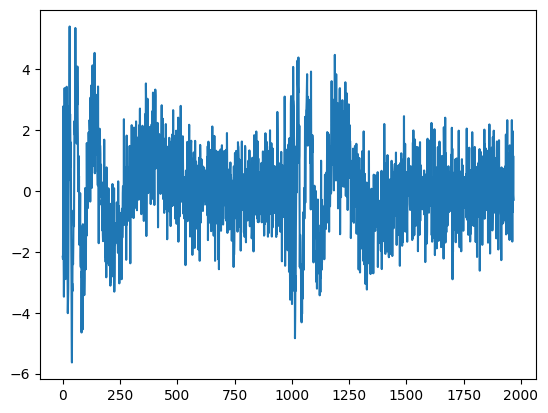

In [8]:
# Get first sample
signal, params = waveform_dataset[0]
signal = signal.cpu()  # Careful to put data back onto CPU.
# Plot signal
plt.plot(signal)
plt.show()

### Split data into train and test dataset

In [9]:
# Split the dataset into training and test sets
num_samples = len(waveform_dataset)
train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Conditional Normalizing Flow

In [10]:
# The glasflow library is a wrapper for nflows (https://github.com/bayesiains/nflows), which implements many different flows.

from glasflow.nflows import transforms, distributions, flows
import glasflow.nflows as nflows
import glasflow.nflows.nn.nets as nflows_nets

device = 'cpu'  # For some reason, "mps" does not work here.

In [11]:
# Code here is adapted from examples in the neural spline flow repository, https://github.com/bayesiains/nsf

# These functions create the transform sequence.

def create_base_transform(
    i: int,
    param_dim: int,
    context_dim: int = None,
    hidden_dim: int = 512,
    num_transform_blocks: int = 2,
    batch_norm: bool = False,
    base_transform_type: str = "maf",
):
    
    activation_fn = torch.nn.ELU()

    if base_transform_type == "maf":
        return transforms.MaskedAffineAutoregressiveTransform(
            param_dim,
            hidden_features=hidden_dim,
            context_features=context_dim,
            num_blocks=num_transform_blocks,
            activation=activation_fn,
            use_batch_norm=batch_norm,
        )

    elif base_transform_type == "rq-coupling":
        if param_dim == 1:
            mask = torch.tensor([1], dtype=torch.uint8)
        else:
            mask = nflows.utils.create_alternating_binary_mask(
                param_dim, even=(i % 2 == 0)
            )
        return transforms.PiecewiseRationalQuadraticCouplingTransform(
            mask=mask,
            transform_net_create_fn=(
                lambda in_features, out_features: nflows_nets.ResidualNet(
                    in_features=in_features,
                    out_features=out_features,
                    hidden_features=hidden_dim,
                    context_features=context_dim,
                    num_blocks=num_transform_blocks,
                    activation=activation_fn,
                    use_batch_norm=batch_norm,
                )
            ),
            num_bins=8,
            tails="linear",
            tail_bound=1.0,
            apply_unconditional_transform=False,
        )

    else:
        raise ValueError


def create_linear_transform(param_dim: int):
    return transforms.CompositeTransform(
        [
            transforms.RandomPermutation(features=param_dim),
            transforms.LULinear(param_dim, identity_init=True),
        ]
    )


def create_transform(
    num_flow_steps: int, param_dim: int, context_dim: int, base_transform_kwargs: dict
):
    return transforms.CompositeTransform(
        [
            transforms.CompositeTransform(
                [
                    create_linear_transform(param_dim),
                    create_base_transform(
                        i, param_dim, context_dim=context_dim, **base_transform_kwargs
                    ),
                ]
            )
            for i in range(num_flow_steps)
        ]
        + [create_linear_transform(param_dim)]
    )

In [12]:
# The entire flow model consists of a standard normal base distribution, followed by the transform.

transform = create_transform(num_flow_steps = 3,
                             param_dim = parameters.shape[-1],
                             context_dim = waveforms.shape[-1],
                             base_transform_kwargs = {"base_transform_type": "maf"})

base_distribution = distributions.StandardNormal(shape=[parameters.shape[-1]])

model = flows.Flow(transform, base_distribution)
model.to(device)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0-2): 3 x CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0): RandomPermutation()
              (1): LULinear()
            )
          )
          (1): MaskedAffineAutoregressiveTransform(
            (autoregressive_net): MADE(
              (initial_layer): MaskedLinear(in_features=2, out_features=512, bias=True)
              (context_layer): Linear(in_features=1970, out_features=512, bias=True)
              (activation): ELU(alpha=1.0)
              (blocks): ModuleList(
                (0-1): 2 x MaskedResidualBlock(
                  (context_layer): Linear(in_features=1970, out_features=512, bias=True)
                  (linear_layers): ModuleList(
                    (0-1): 2 x MaskedLinear(in_features=512, out_features=512, bias=True)
                  )
                  (activation): ELU(alpha=1.0)
 

### Training

In [13]:
# Training and test loops

def train_loop(dataloader, model, optimizer):

    model.train()
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss  
        loss = - model.log_prob(y, X)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss

        
def test_loop(dataloader, model):

    model.eval()
    
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            loss = - model.log_prob(y, X)
            test_loss += loss.sum()

    test_loss = test_loss.item() / size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 4.375834  [    0/ 8000 samples]
Loss: 1.500499  [ 3200/ 8000 samples]
Loss: 0.591483  [ 6400/ 8000 samples]
Average loss: 2.1544
Test loss: 0.259420 

Epoch 2
-------------------------------
Loss: 0.302418  [    0/ 8000 samples]
Loss: 0.603217  [ 3200/ 8000 samples]
Loss: -0.555735  [ 6400/ 8000 samples]
Average loss: -0.0138
Test loss: -0.178200 

Epoch 3
-------------------------------
Loss: -0.075264  [    0/ 8000 samples]
Loss: -0.729265  [ 3200/ 8000 samples]
Loss: -0.876377  [ 6400/ 8000 samples]
Average loss: -0.5959
Test loss: -0.873963 

Epoch 4
-------------------------------
Loss: -0.829099  [    0/ 8000 samples]
Loss: -0.464111  [ 3200/ 8000 samples]
Loss: -0.864261  [ 6400/ 8000 samples]
Average loss: -0.8857
Test loss: -1.140302 

Epoch 5
-------------------------------
Loss: -0.544327  [    0/ 8000 samples]
Loss: -1.300466  [ 3200/ 8000 samples]
Loss: -1.668694  [ 6400/ 8000 samples]
Average loss: -1.2503
Test loss: -1.460375

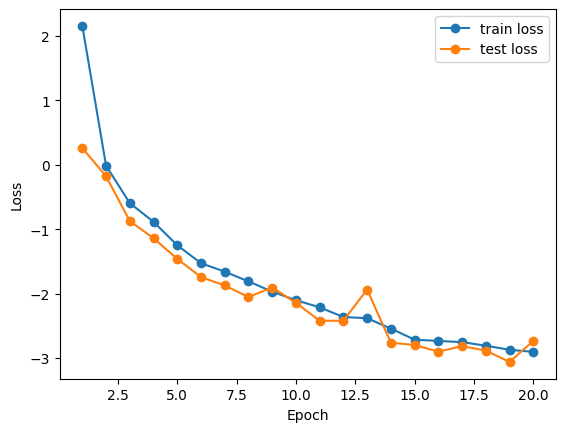

In [15]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, '-o', label = 'train loss')
plt.plot(epochs, test_history, '-o', label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualize posteriors

[38.882786 22.94932 ]


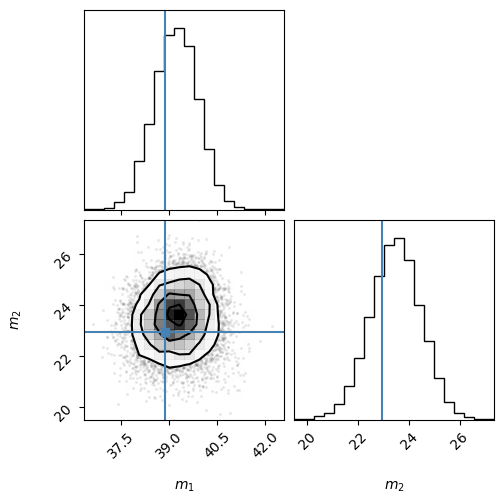

[46.974144 24.75185 ]


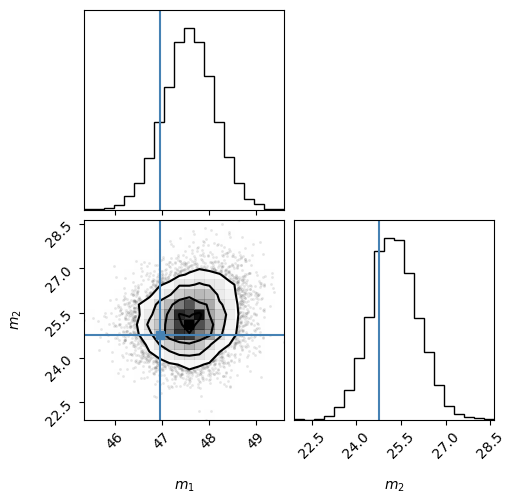

[73.04515  40.491184]


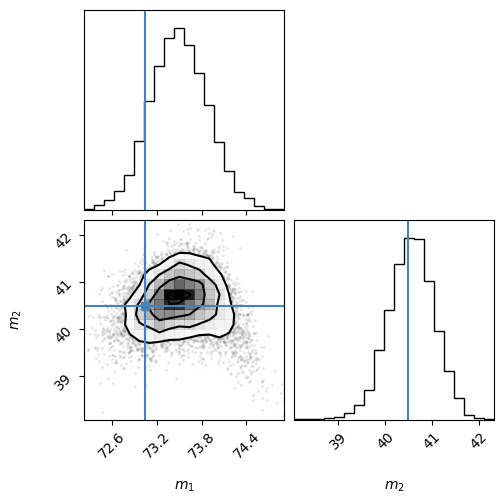

[61.228893 51.43555 ]


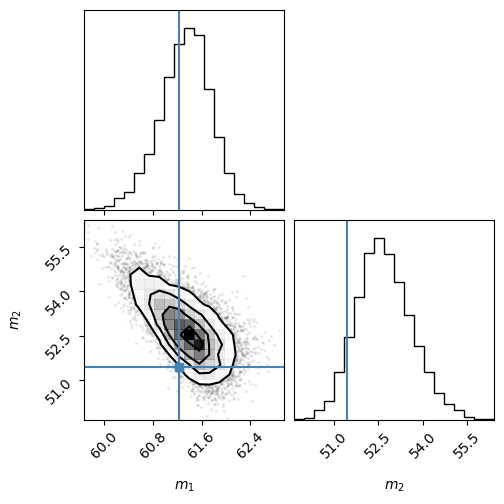

[52.436577 46.380817]


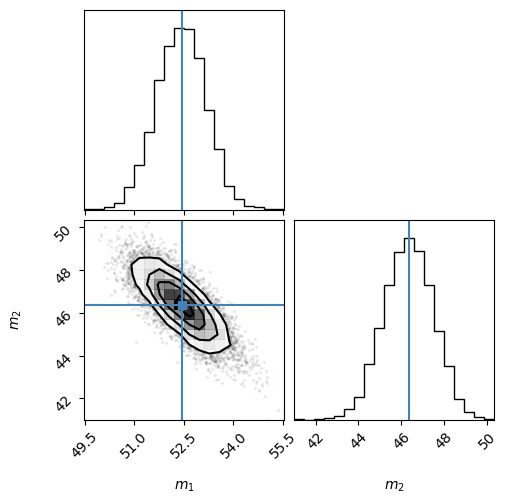

[73.83716 67.66749]


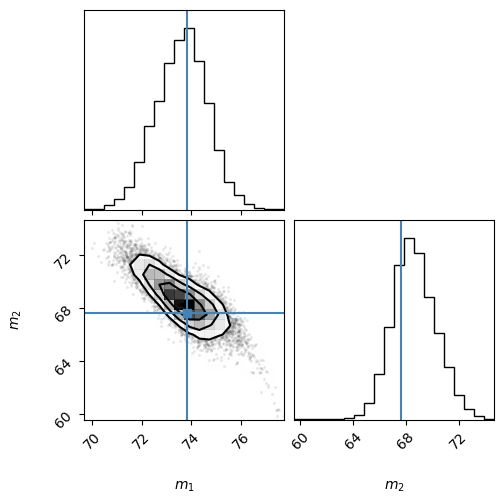

[65.94285  36.043648]


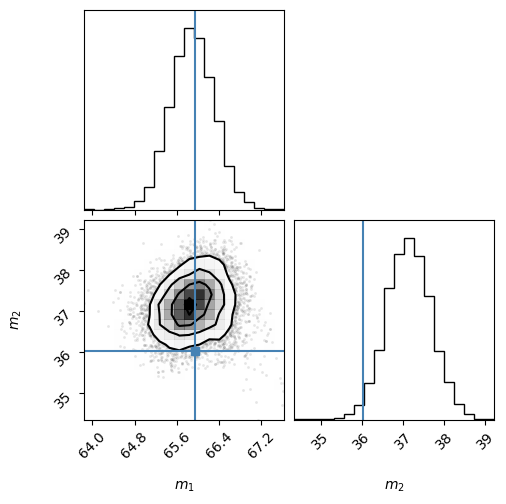

[53.982983 25.026445]


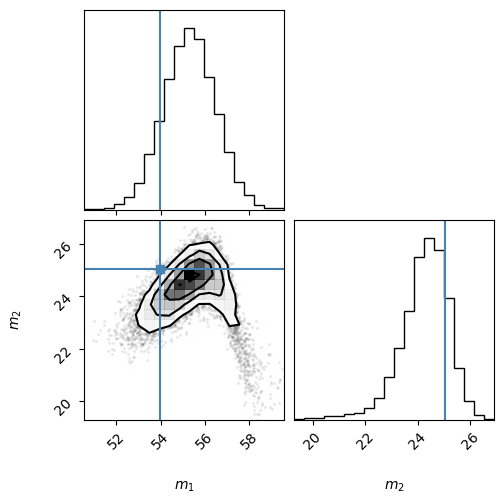

[76.38866  69.760704]


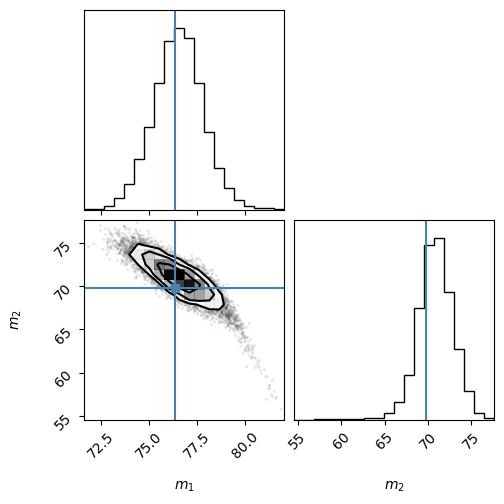

[76.42351  50.944958]


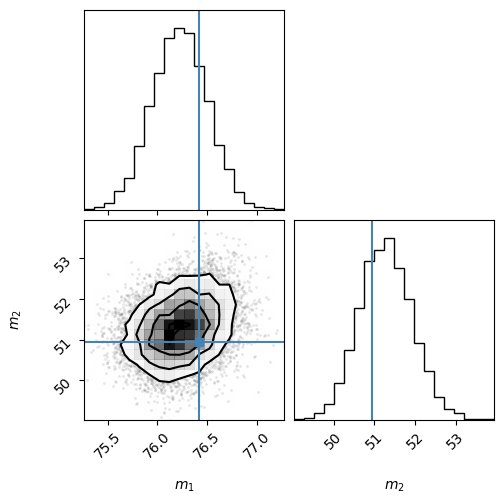

In [16]:
num_posteriors = 10
num_eval_samples = 10_000

model.eval()

for n in range(num_posteriors):

    with torch.no_grad():
    
        test_x, test_y = test_dataset[n]
       
        # Sample the posterior
        test_x = test_x.expand(num_eval_samples, *test_x.shape)
        pred_samples = model.sample(1, test_x).squeeze(1).cpu().numpy()
    
        # Undo the standardization
        pred_samples = parameters_std * pred_samples + parameters_mean
        truth = parameters_std * test_y.cpu().numpy() + parameters_mean
        print(truth)
    
        # Plot
        corner.corner(pred_samples, truths=truth, labels=['$m_1$', '$m_2$'])
        plt.show()

### Tasks:
- It is often easier to learn a posterior that is not defined by the masses $m_1, m_2$ of the black holes directly, but by the chirp mass $\mathcal{M} = \frac{(m_1 \cdot m_2)^{3/5}}{(m_1 + m_2)^{1/5}}$ and mass ratio $q = \frac{m_2}{m_1}$. Re-define the input parameters and compare whether this improves training.
- 